In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from gym import spaces
import random
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [7]:
# 그리드 맵 로드
grid_map = np.load('land_sea_grid_cartopy.npy')  # 생성된 .npy 파일 로드

# 그리드 크기
n_rows, n_cols = grid_map.shape  # 810, 710

# 위경도 범위 (맵 생성 코드와 동일)
lat_min, lat_max = 30, 38
lon_min, lon_max = 120, 127

# 위경도를 그리드 좌표로 변환하는 함수
def latlon_to_grid(lat, lon):
    y = int((lat - lat_min) / (lat_max - lat_min) * (n_rows - 1))
    x = int((lon - lon_min) / (lon_max - lon_min) * (n_cols - 1))
    return y, x

# 출발지와 도착지 예시 (인천항 -> 상하이항)
start_lat, start_lon = 37.46035, 126.62360  # 인천항
end_lat, end_lon = 30.62828, 122.06400      # 상하이항
start_y, start_x = latlon_to_grid(start_lat, start_lon)
end_y, end_x = latlon_to_grid(end_lat, end_lon)
print(f"출발지: ({start_y}, {start_x}), 도착지: ({end_y}, {end_x})")

출발지: (754, 670), 도착지: (63, 209)


In [8]:
class SeaRouteEnv:
    def __init__(self, grid_map, start, end):
        self.grid_map = grid_map
        self.start = start  # (y, x)
        self.end = end      # (y, x)
        self.current_position = start
        self.action_space = spaces.Discrete(8)  # 8방향 이동
        self.observation_space = spaces.MultiDiscrete([n_rows, n_cols])
        self.max_steps = 5000
        self.current_step = 0
        # 이동 방향: 상, 우상, 우, 우하, 하, 좌하, 좌, 좌상
        self.actions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

    def reset(self):
        self.current_position = self.start
        self.current_step = 0
        return self.current_position

    def step(self, action):
        y, x = self.current_position
        dy, dx = self.actions[action]
        next_y, next_x = y + dy, x + dx

        # 이동 거리에 따른 기본 비용
        dist = np.sqrt(dy**2 + dx**2)
        reward = -dist
        done = False

        # 다음 위치 유효성 검사
        if 0 <= next_y < n_rows and 0 <= next_x < n_cols:
            if self.grid_map[next_y, next_x] == 0:  # 바다 (0)
                self.current_position = (next_y, next_x)
                if (next_y, next_x) == self.end:    # 목표 도달
                    reward = 100
                    done = True
            else:  # 육지 (1)
                reward = -10  # 육지 이동 불가
        else:  # 그리드 밖
            reward = -10

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True

        return self.current_position, reward, done, {}

    def render(self):
        pass  # 시각화는 나중에

In [9]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

사용 중인 디바이스: cuda


In [10]:
# 하이퍼파라미터
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 64
memory_size = 10000
target_update = 10

# 모델 초기화
state_dim = 2  # (y, x)
action_dim = 8  # 8방향
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

# 행동 선택 함수
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state)
        return q_values.argmax().item()

# 환경 초기화
env = SeaRouteEnv(grid_map, (start_y, start_x), (end_y, end_x))

# 학습 루프
episodes = 1000
progress_bar = tqdm(range(episodes), desc="학습 진행")
for episode in progress_bar:
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # 학습
        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.long).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)

            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_net(next_states).max(1)[0]
            target_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 타겟 네트워크 업데이트 및 epsilon 감소
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    progress_bar.set_postfix({"보상": total_reward})

학습 진행:   0%|          | 0/1000 [00:00<?, ?it/s]

최적 경로: [(754, 670), (755, 670), (756, 670), (757, 670), (758, 670), (759, 670), (760, 670), (761, 670), (762, 670), (763, 670), (764, 670), (765, 670), (766, 670), (767, 670), (768, 670), (769, 670), (770, 670), (771, 670), (772, 670), (773, 670), (774, 670), (775, 670), (776, 670), (777, 670), (778, 670), (779, 670), (779, 669), (779, 668), (779, 667), (779, 666), (779, 665), (779, 664), (779, 663), (779, 662), (779, 661), (779, 660), (779, 659), (779, 658), (779, 657), (779, 656), (779, 655), (779, 654), (779, 653), (779, 652), (779, 651), (779, 650), (779, 649), (779, 648), (779, 647), (779, 646), (779, 645), (779, 644), (779, 643), (779, 642), (779, 641), (779, 640), (779, 639), (779, 638), (779, 637), (779, 636), (779, 635), (779, 634), (779, 633), (779, 632), (779, 631), (779, 630), (779, 629), (779, 628), (779, 627), (779, 626), (779, 625), (779, 624), (779, 623), (779, 622), (779, 621), (779, 620), (779, 619), (779, 618), (779, 617), (779, 616), (779, 615), (779, 614), (779, 61

C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramproject\sibal\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\baramp

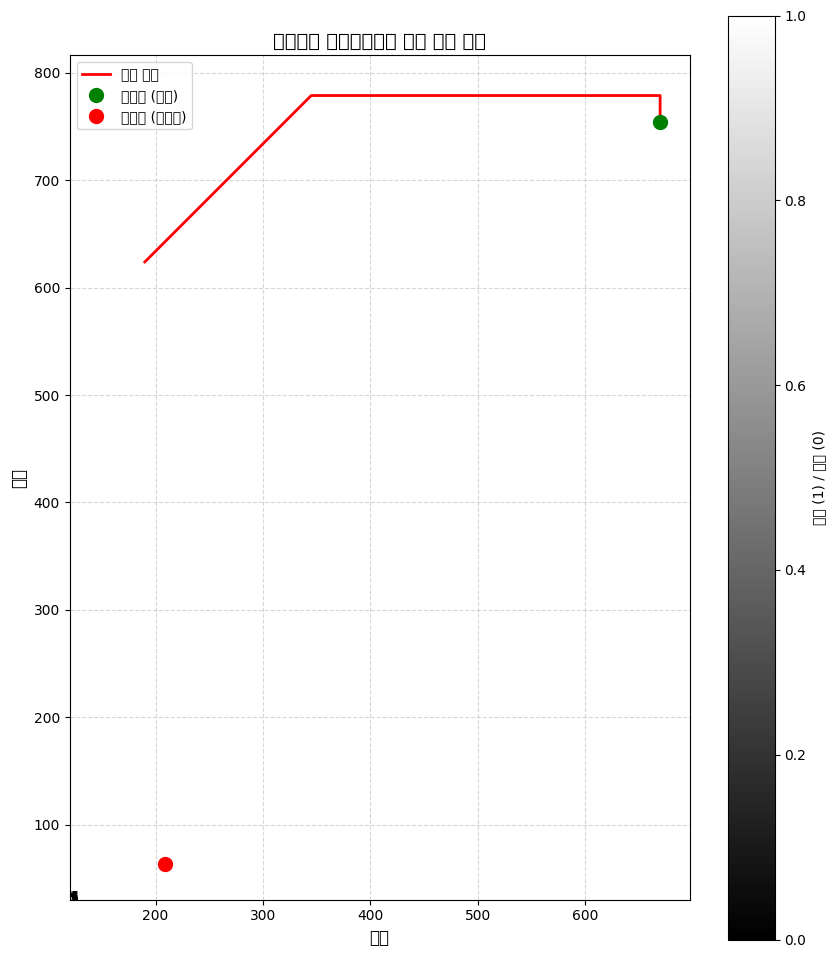

In [11]:
# 최적 경로 추출
state = env.reset()
path = [state]
done = False
while not done:
    action = select_action(state, epsilon=0)  # 탐험 없이 최적 행동 선택
    next_state, reward, done, _ = env.step(action)
    path.append(next_state)
    state = next_state

print("최적 경로:", path)

# 시각화
plt.figure(figsize=(10, 12))
plt.imshow(grid_map, cmap='gray', origin='upper', extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='육지 (1) / 바다 (0)')

# 경로를 그리드 좌표로 플롯
path_y, path_x = zip(*path)
plt.plot(path_x, path_y, 'r-', linewidth=2, label='최적 경로')

# 출발지와 도착지 표시
plt.plot(start_x, start_y, 'go', markersize=10, label='출발지 (인천)')
plt.plot(end_x, end_y, 'ro', markersize=10, label='도착지 (상하이)')

plt.title("인천에서 상하이까지의 최적 해상 경로", fontsize=14)
plt.xlabel("경도", fontsize=12)
plt.ylabel("위도", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()